In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 83 kB/s 


In [2]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 7.0 MB/s 
     |████████████████████████████████| 81 kB 11.5 MB/s 
     |████████████████████████████████| 209 kB 66.8 MB/s 
     |████████████████████████████████| 78 kB 8.9 MB/s 
     |████████████████████████████████| 49 kB 7.6 MB/s 
     |████████████████████████████████| 147 kB 60.0 MB/s 
     |████████████████████████████████| 112 kB 73.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=13827e0d22f8deb6e634d8f38b27d752a31f40868094356ea1b15d071f045dab
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# import moduel은 그냥 복붙한거라서 어떤게 맞을지 잘 모릅니다

import numpy as np
import pandas as pd
from scipy.stats import uniform, randint

from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb
from xgboost import plot_importance
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tqdm import tnrange, tqdm

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import catboost
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/SW 중심대학 예선/Data/train.csv', index_col=0)
test_df = pd.read_csv('/content/drive/MyDrive/SW 중심대학 예선/Data/test.csv', index_col=0)
sample_submission = pd.read_csv('/content/drive/MyDrive/SW 중심대학 예선/Data/sample_submission.csv')

In [6]:
def fill_na_mode(data):   
    # fill with mode. (최빈값 fillna)
    fill_null_list = list(data.columns)
    for col in fill_null_list:
        data[col].fillna(data[col].mode()[0],inplace=True)

    return data

def country_imputation(data):
    
    data.loc[(data.country == 'IMN'), 'country'] = 'GBR'
    data.loc[(data.country == 'REU'), 'country'] = 'MDG'
    data.loc[(data.country == 'ZWE'), 'country'] = 'ZAF'
    data.loc[(data.country == 'SWZ'), 'country'] = 'ZAF'
    data.loc[(data.country == 'LKA'), 'country'] = 'ZAF'
    data.loc[(data.country == 'SLE'), 'country'] = 'ZAF'
    data.loc[(data.country == 'BFA'), 'country'] = 'ZAF'
    data.loc[(data.country == 'TZA'), 'country'] = 'ZAF'
    data.loc[(data.country == 'BOL'), 'country'] = 'ZAF'
    data.loc[(data.country == 'PSE'), 'country'] = 'ZAF'
    data.loc[(data.country == 'MDA'), 'country'] = 'UKR'
    data.loc[(data.country == 'CYM'), 'country'] = 'JAM'
    data.loc[(data.country == 'NIC'), 'country'] = 'JAM'
    data.loc[(data.country == 'MCO'), 'country'] = 'USA'
    data.loc[(data.country == 'MNE'), 'country'] = 'COL'
    data.loc[(data.country == 'GRD'), 'country'] = 'VEN'
    data.loc[(data.country == 'LCA'), 'country'] = 'VEN'
    data.loc[(data.country == 'VUT'), 'country'] = 'AUS'
    data.loc[(data.country == 'BLZ'), 'country'] = 'BRA'
    data.loc[(data.country == 'ATG'), 'country'] = 'PRI'
    data.loc[(data.country == 'JEY'), 'country'] = 'FRA'
    data.loc[(data.country == 'HTI'), 'country'] = 'DOM'
    data.loc[(data.country == 'FSM'), 'country'] = 'NAM'
    data.loc[(data.country == 'SSD'), 'country'] = 'ARM'
    return data
    

# VCL 모두 삭제
def drop_vcl(df):
    
    col_list = [f'VCL{i}' for i in range(1, 17)] 
    
    for col in col_list:
        df.drop(col, axis=1, inplace=True)
    
    return df

# Q 답변 변환
def q_data(data):
    
    Q_list = [f'Q{i}' for i in range(1, 27)]
    reverse_list = ['Q3', 'Q4', 'Q7', 'Q9', 'Q10', 'Q11', 'Q16', 'Q17']
    
    for rev in reverse_list: 
        data[rev] = 6 - data[rev]
        
    data['Mach_score'] = data[Q_list].mean(axis = 1)
    
    return data

# TIPI feature  engineering 
def tipi_engineering(data):
    
    data['Conscientiousness'] = (data['TIPI3']+(6-data['TIPI8']))/2
    data['Agreeableness'] = (data['TIPI7']+(6-data['TIPI2']))/2
    data['Neuroticism'] = (data['TIPI9']+(6-data['TIPI4']))/2
    data['openness'] = (data['TIPI5']+(6-data['TIPI10']))/2
    data['extraversion'] = (data['TIPI1']+(6-data['TIPI6']))/2
    
    for x in [2, 4, 6, 8, 10]:
        data[f'TIPI{x}'] = 6 - data[f'TIPI{x}']
    
    return data

# correlation이 낮은 introelapse 제거 
def drop_introelapse(data):
    
    data.drop('introelapse', axis=1, inplace=True)
    
    return data

# one-hot encoding 적용 
def onehot_encoding(data):
    
    onehot_list = ['education','urban', 'gender', 'engnat', 'hand', 'religion', 'orientation','voted', 'married', 'ASD', 'country']

    for col in onehot_list:
        data = pd.get_dummies(data = data, columns = [col], prefix = col)

    return data

# ageband로 묶어서 age 계산
def ageband(data):
    data['ageBand'] = -1
    data.loc[(data['age'] > 12) & (data['age'] <= 20.0), 'ageBand'] = 1
    data.loc[(data['age'] > 20.0) & (data['age'] <= 26.0), 'ageBand'] = 2
    data.loc[(data['age'] > 26.0) & (data['age'] < 130), 'ageBand'] = 3
    data.drop('age',axis=1,inplace=True)
    return data

def outlier_func(data):
    
    for i in ['testelapse','surveyelapse']:
        data.loc[data[i]>6000,i] = 6000

    #familysize
    data.loc[data['familysize']>10,'familysize'] = 10
  
    return data
'''
def country_func(data):
    
    temp = data['country'].value_counts().rename_axis('unique_values').reset_index(name='counts')
    country_list = list(temp[temp['counts']>10]['unique_values'].unique())
    data.loc[~data['country'].isin(country_list),'country'] = 'others'
    data = pd.get_dummies(data = data, columns = ['country'], prefix = 'country')
    return data
'''

"\ndef country_func(data):\n    \n    temp = data['country'].value_counts().rename_axis('unique_values').reset_index(name='counts')\n    country_list = list(temp[temp['counts']>10]['unique_values'].unique())\n    data.loc[~data['country'].isin(country_list),'country'] = 'others'\n    data = pd.get_dummies(data = data, columns = ['country'], prefix = 'country')\n    return data\n"

In [7]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.min_rows', 30)

def processing_data(data):
    data = country_imputation(data)
    data = outlier_func(data)
    data = drop_introelapse(data)
    data = drop_vcl(data)
    data = fill_na_mode(data)
    data = onehot_encoding(data)
    data = q_data(data)
    data = tipi_engineering(data)
    data = ageband(data)
    # data = country_func(data) # 여기서 문제 발생. 
    
    return data

In [8]:
train_df = processing_data(train_df)
test_df = processing_data(test_df)

train_X = train_df.drop('nerdiness', axis = 1)
train_Y = train_df['nerdiness']

forward feature selection

In [9]:
import statsmodels.api as sm

In [10]:
target = train_df['nerdiness']

In [11]:
features = list(train_df.columns)
features.remove('nerdiness')

In [12]:
## 전진 선택법
variables = features ## 설명 변수 리스트
 
y = train_df['nerdiness'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = train_df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(train_df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14:

In [13]:
len(train_df.columns)

222

In [14]:
len(selected_variables)

41

In [ ]:
real_score = []

def objective(trial, data=train_X, target=train_Y):
    
    score = []
    kf = StratifiedKFold(n_splits = 10, random_state = 42 , shuffle = True)

    for train_fold, test_fold in tqdm(kf.split(train_X, train_Y), desc = 'k_fold'):
        X_train, X_test, y_train, y_test = train_X.iloc[train_fold], train_X.iloc[test_fold], train_Y[train_fold], train_Y[test_fold] 
        params = {
            "objective": "multi:softprob",
            "eval_metric":'mlogloss', # ['auc', 'error']
            "booster": 'gbtree', 
            'tree_method':'gpu_hist', 'predictor':'gpu_predictor', 'gpu_id': 0, # use this line for gpu usage.
            # "tree_method": 'exact', 'gpu_id': -1,  # CPU 사용시 
            "verbosity": 0,
            'num_class':3,
            "max_depth": trial.suggest_int("max_depth", 4, 10), 
            "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
            'n_estimators': trial.suggest_int("n_estimators", 1000, 10000, step=100), 
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0), 
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
            "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
            "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
            "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1),
            'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),      
            'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
            "gamma": trial.suggest_float("gamma", 0.1, 1.0, log=True),
            # 'num_parallel_tree': trial.suggest_int("num_parallel_tree", 1, 500)
        }

        model = xgb.XGBClassifier(**params)  
        
        model.fit(X_train,y_train,eval_set=[(X_test,y_test)],verbose=False)
        
        preds = model.predict_proba(X_test)[:, 1]
        fpr, tpr, threshold = roc_curve(y_test, preds)
        auc_score = auc(fpr, tpr)
        score.append(auc_score)
        real_score.append(auc_score)

    return np.mean(score)


'''
0.8558211379019417 and parameters: {'max_depth': 10, 'learning_rate': 0.11423799062437275, 'n_estimators': 6900, 'colsample_bytree': 0.7390924842332742, 'colsample_bylevel': 0.6940109759294105, 'colsample_bynode': 0.5496585400738032, 'reg_lambda': 0.9713492867033704, 'reg_alpha': 0.8147232205798981, 'subsample': 0.85, 'min_child_weight': 5, 'gamma': 0.16280391709890213}
0.8765662376664448 and parameters: {'max_depth': 10, 'learning_rate': 0.025929426661789656, 'n_estimators': 6600, 'colsample_bytree': 0.7155456762839627, 'colsample_bylevel': 0.6123744502366096, 'colsample_bynode': 0.8016499020606728, 'reg_lambda': 0.0935399629775155, 'reg_alpha': 0.018771877229402035, 'subsample': 0.8, 'min_child_weight': 4, 'gamma': 0.6677845409584143}
'''

sampler = TPESampler(seed = 42)

optim = optuna.create_study(direction="maximize")

optim.optimize(objective, n_trials=20) 
print("Best auc:", optim.best_value)

[I 2022-08-26 03:03:54,972] A new study created in memory with name: no-name-8b461c24-ac9f-45f6-9bd1-51464f5f5035
k_fold: 10it [05:53, 35.30s/it]
[I 2022-08-26 03:09:48,027] Trial 0 finished with value: 0.8422265294361303 and parameters: {'max_depth': 5, 'learning_rate': 0.9707786570812442, 'n_estimators': 5100, 'colsample_bytree': 0.7326219028600898, 'colsample_bylevel': 0.924688888560206, 'colsample_bynode': 0.6098501968786746, 'reg_lambda': 0.02885796047574041, 'reg_alpha': 0.020336720872054806, 'subsample': 0.7, 'min_child_weight': 4, 'gamma': 0.8692568833245904}. Best is trial 0 with value: 0.8422265294361303.
k_fold: 10it [10:05, 60.56s/it]
[I 2022-08-26 03:19:53,615] Trial 1 finished with value: 0.8573445868028369 and parameters: {'max_depth': 6, 'learning_rate': 0.13196563562419664, 'n_estimators': 6500, 'colsample_bytree': 0.5203666591633518, 'colsample_bylevel': 0.5191322647103738, 'colsample_bynode': 0.8643360471413679, 'reg_lambda': 0.015720750220401494, 'reg_alpha': 0.1070

In [ ]:
params = {
    'max_depth': 10, 
    'learning_rate': 0.00976136092905561, 
    'n_estimators': 9400, 
    'colsample_bytree': 0.8543754171382677, 
    'colsample_bylevel': 0.9629904399168124, 
    'colsample_bynode': 0.8248938119302215, 
    'reg_lambda': 0.19485954543028522, 
    'reg_alpha': 0.06999603044690161, 
    'subsample': 0.75, 
    'min_child_weight': 2, 
    'gamma': 0.11753760508543808
    }
xgb_model = xgb.XGBClassifier(**params)
xgb_model.fit(train_X, train_Y)

y_pred = xgb_model.predict(test_df)
sample_submission['nerdiness'] = y_pred

In [ ]:
sample_submission.to_csv('/content/drive/MyDrive/SW 중심대학 예선/Result/sample_submission_0827.csv', index=False)

## different perspective

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.2, random_state=123 )

In [ ]:
# get_clf_eval()
# 저번에 작성한 것에 ROC AUC를 추가함
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'
          .format(accuracy, precision, recall, f1, roc_auc))
    
# get_eval_by_threshold()
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration하면서 evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print(f'임곗값: {custom_threshold}')
        get_clf_eval(y_test, custom_predict)

# precision_recall_curve_plot()
def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행, 정밀도는 점선으로 표시
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X축의 scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # X, Y축 label과 legend, grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()

In [ ]:
dtrain, dtest = xgb.DMatrix(X_train, y_train), xgb.DMatrix(X_test, y_test)

In [ ]:
params = {
    'max_depth': 10, 
    'learning_rate': 0.00976136092905561, 
    'n_estimators': 9400, 
    'colsample_bytree': 0.8543754171382677, 
    'colsample_bylevel': 0.9629904399168124, 
    'colsample_bynode': 0.8248938119302215, 
    'reg_lambda': 0.19485954543028522, 
    'reg_alpha': 0.06999603044690161, 
    'subsample': 0.75, 
    'min_child_weight': 2, 
    'gamma': 0.11753760508543808
    }
num_rounds = 10000

In [ ]:
wlist = [(dtrain, 'train'), (dtest, 'eval')]
xgb_model = xgb.train(params, dtrain, num_rounds, early_stopping_rounds=100, evals=wlist)

[0]	train-rmse:0.497716	eval-rmse:0.498603
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:0.495381	eval-rmse:0.497195
[2]	train-rmse:0.493204	eval-rmse:0.49594
[3]	train-rmse:0.49101	eval-rmse:0.494615
[4]	train-rmse:0.488784	eval-rmse:0.493339
[5]	train-rmse:0.486659	eval-rmse:0.492036
[6]	train-rmse:0.484496	eval-rmse:0.490799
[7]	train-rmse:0.482316	eval-rmse:0.48952
[8]	train-rmse:0.480252	eval-rmse:0.488345
[9]	train-rmse:0.478022	eval-rmse:0.487079
[10]	train-rmse:0.475935	eval-rmse:0.485963
[11]	train-rmse:0.473938	eval-rmse:0.484827
[12]	train-rmse:0.471944	eval-rmse:0.483736
[13]	train-rmse:0.469911	eval-rmse:0.482539
[14]	train-rmse:0.467943	eval-rmse:0.481491
[15]	train-rmse:0.465908	eval-rmse:0.480426
[16]	train-rmse:0.463856	eval-rmse:0.479342
[17]	train-rmse:0.46194	eval-rmse:0.478263
[18]	train-rmse:0.460066	eval-rmse:0.477227
[19]	train-rmse:0.458096	eval-rmse

KeyboardInterrupt: ignored

In [ ]:
pred_probs = xgb_model.predict(dtest)
preds = [1 if x > 0.5 else 0 for x in pred_probs]
get_clf_eval(y_test, preds, pred_probs)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

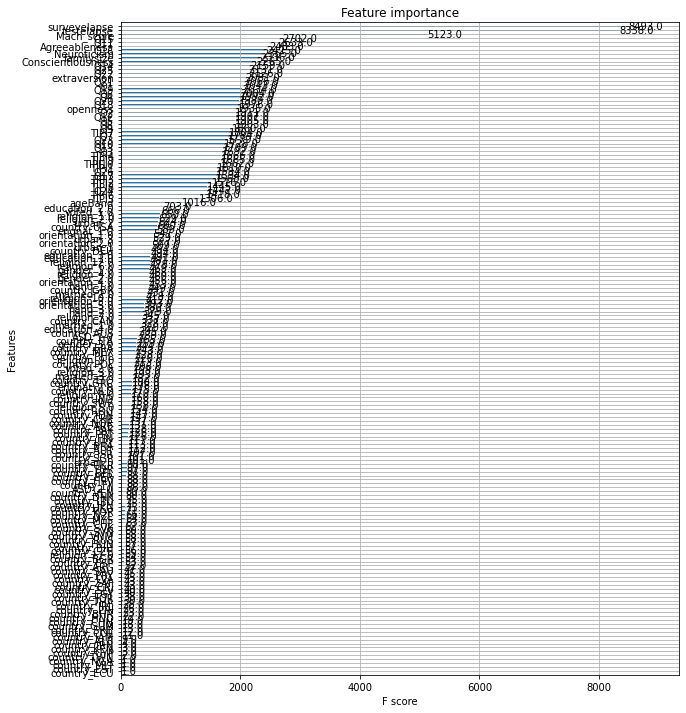

In [ ]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)